# Init

In [1]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
seaborn.set_style('whitegrid')

In [2]:
# read csv's into dataframes

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')

print('Train')
print(train.info())
print('\n Test')
print(test.info())
print('\n Store')
print(store.info())

/Users/Max/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None

 Test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
m

# Analyze missing stores

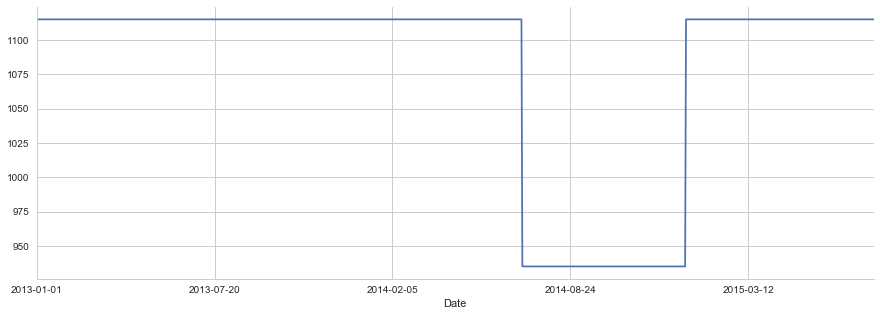

In [3]:
# Information says stores were closed, check for closed stores

fig, ax = plt.subplots(figsize=(15,5))
train['Store'].groupby(train['Date']).size().plot(kind='line')
seaborn.despine()


Stores missing for a period in time, however we will be training the data on only open stores anyway. We will be performing a regression analysis which is quite sensitive to outliers. We will thus add data with the missing stores open on these days (except Sundays, which we will confirm in the next output) and having mean sales and customer data.

In short, our assumption here is that we are assuming that these stores will be open in the 6 weeks we are predicting and using the average of present data will lead to more representative results for these days.

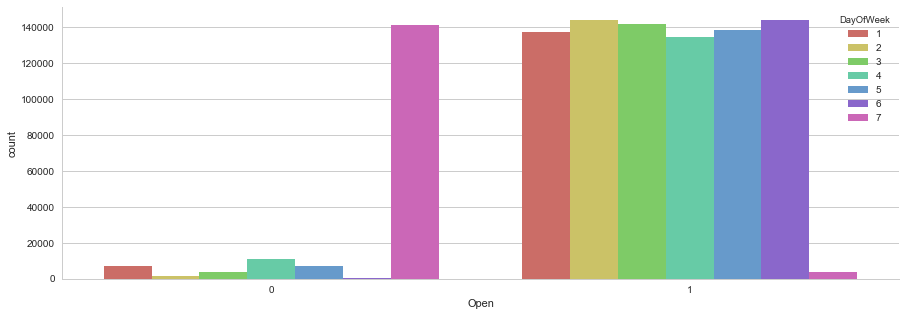

In [4]:
# Confirm stores are closed on sundays

fig, ax = plt.subplots(figsize=(15,5))
seaborn.countplot(x='Open',hue='DayOfWeek', data=train, palette='hls', ax=ax)
seaborn.despine()

# Smooth missing stores

In [5]:
from datetime import datetime

subset = train
subset['Date'] = pd.to_datetime(subset['Date'])
subset = subset[(subset['Date'] >= datetime(2014,7,1)) & (subset['Date'] < datetime(2015,1,1))]

# here we use the average number of customers and sales in the period we see above, this is a rough estimate as there's daily variation
avg_customers = int(subset['Customers'].mean())
avg_sales = int(subset['Sales'].mean())

def add_missing_dates(train, all_stores):
    train_m = pd.DataFrame()
    store_by_date = train.groupby('Date')['Store'].nunique().reset_index()
    for i in store_by_date.query('Store != 1115')['Date']:
        diff_stores = all_stores.difference(set(train[train['Date']==i].Store))
        s = list(diff_stores)
        if i.isoweekday() in [1,2,3,4,5,6]: # on weekdays
            missing = pd.DataFrame(data={
                                     'Date': [i]*len(s),
                                     'Store': s, 
                                     'Customers': [avg_customers]*len(s), #avg sales for specified period
                                     'Sales': [avg_sales]*len(s), # avg customers for specified period
                                     'Open': [1]*len(s), # stores are open
                                     'Promo': [0]*len(s),
                                     'SchoolHoliday': [0]*len(s),
                                     'StateHoliday': ['0']*len(s),
                                    })
            
        else: # on sundays
            missing = pd.DataFrame(data={
                                     'Date': [i]*len(s),
                                     'Store': s, 
                                     'Customers': [0]*len(s), # no customers
                                     'Sales': [0]*len(s), # no sales
                                     'Open': [0]*len(s), # stores not open
                                     'Promo': [0]*len(s),
                                     'SchoolHoliday': [0]*len(s),
                                     'StateHoliday': ['0']*len(s),
                                    }) 
    
        train_m = train_m.append(missing)
        train_m['Date'] = pd.to_datetime(train_m['Date'])
        train_m['DayOfWeek'] = train_m['Date'].dt.dayofweek+1
    
    return train_m[['Store','DayOfWeek','Date','Sales','Customers','Open','Promo','StateHoliday','SchoolHoliday']]

This smoothing does NOT lead to better results. So the function is not applied to the dataset.

In [6]:
train2 = train.copy()
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


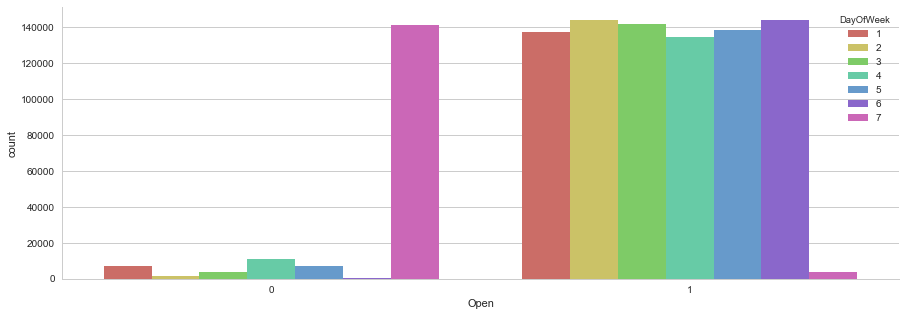

In [7]:
# Confirm stores are still closed on sundays

fig, ax = plt.subplots(figsize=(15,5))
seaborn.countplot(x='Open',hue='DayOfWeek', data=train2, palette='hls', ax=ax)
seaborn.despine()

# Feature visualization

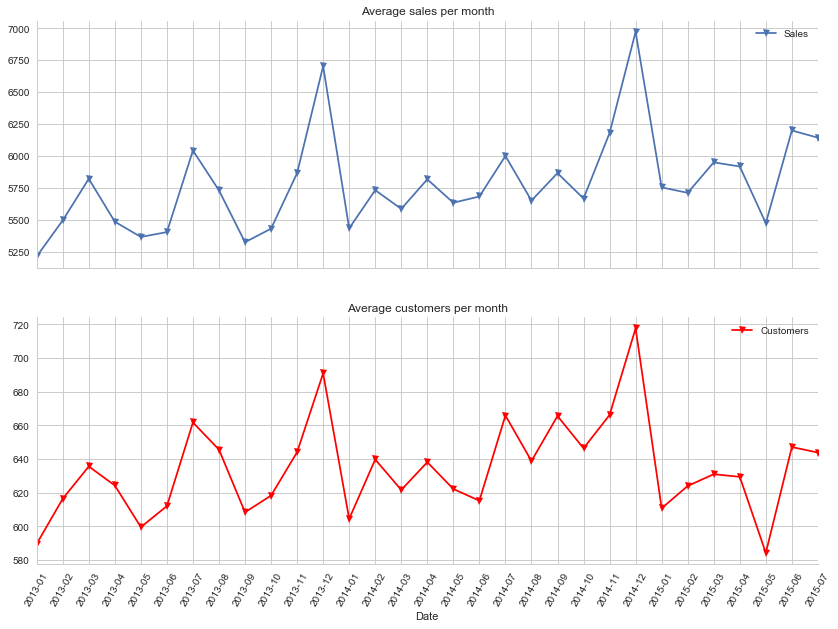

In [8]:
# Average sales and customers per month

# Calculate average sales per month
train2['month_date'] = train2['Date'].apply(lambda x: (str(x)[:7]))
avg_sales = train2['Sales'].groupby(train2['Date'].apply(lambda x: (str(x)[:7]))).mean()
avg_customers = train2['Customers'].groupby(train2['Date'].apply(lambda x: (str(x)[:7]))).mean()

# Plot values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10), sharex=True)
seaborn.despine()

# Average sales
ax1 = avg_sales.plot(legend=True, ax=ax1, marker='v', title='Average sales per month')
ax1.set_xticks(range(len(avg_sales)))
ax1.set_xticklabels(avg_sales.index.tolist(), rotation=60)

# Average customers
ax2 = avg_customers.plot(legend=True, ax=ax2, marker='v', title='Average customers per month', color='red')
ax2.set_xticklabels(avg_sales.index.tolist(), rotation=60)

There's clear trends showing a drop to minimum around August/September, our months of interest. I suspect it has to do with the schools starting again. We can check this quite easily.

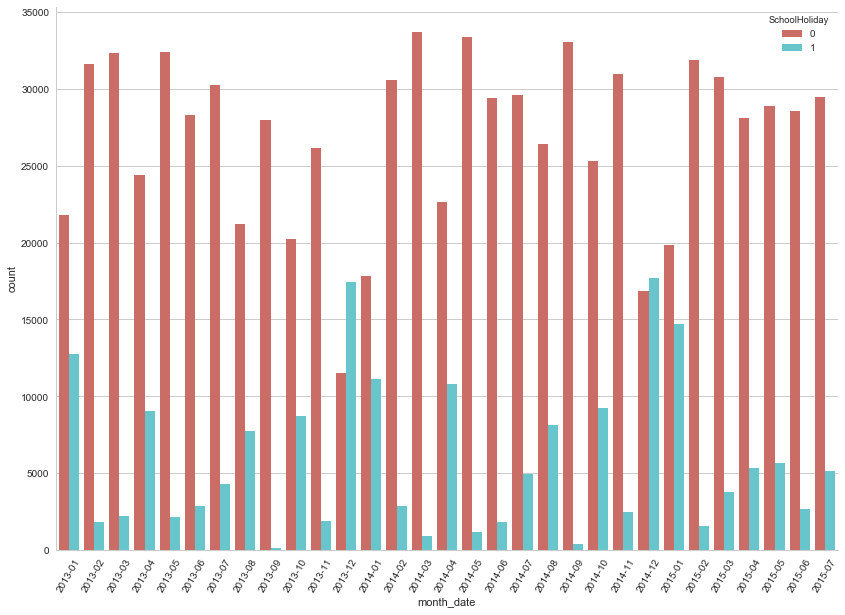

In [9]:
fig, ax = plt.subplots(figsize=(14,10))
seaborn.despine()
seaborn.countplot(x='month_date',hue='SchoolHoliday', data=train2, palette='hls', ax=ax)
ax.set_xticklabels(avg_sales.index.tolist(), rotation=60)

We definitely have to account for strong seasonal effect around September due to end of school holiday. From this I want to try limiting the training set on only the __relevant dates (Aug. 1 - Sept. 17).__ Let's see if there's any annual effects to take into account which would affect this kind of filtering.

In [10]:
# The percent increase per year is calculated here

avg_sales_per_year = train2['Sales'].groupby(train2['month_date'].apply(lambda x: (str(x)[:4]))).mean()

delta1 = round((avg_sales_per_year['2014']/avg_sales_per_year['2013'] - 1)*100,2)
delta2 = round((avg_sales_per_year['2015']/avg_sales_per_year['2014'] - 1)*100,2)

print('Sales in 2013 to 2014 increased by',delta1,'%')
print('\n'+'Sales in 2014 to 2015 increased by',delta2,'%')

Sales in 2013 to 2014 increased by 3.09 %

Sales in 2014 to 2015 increased by 0.77 %


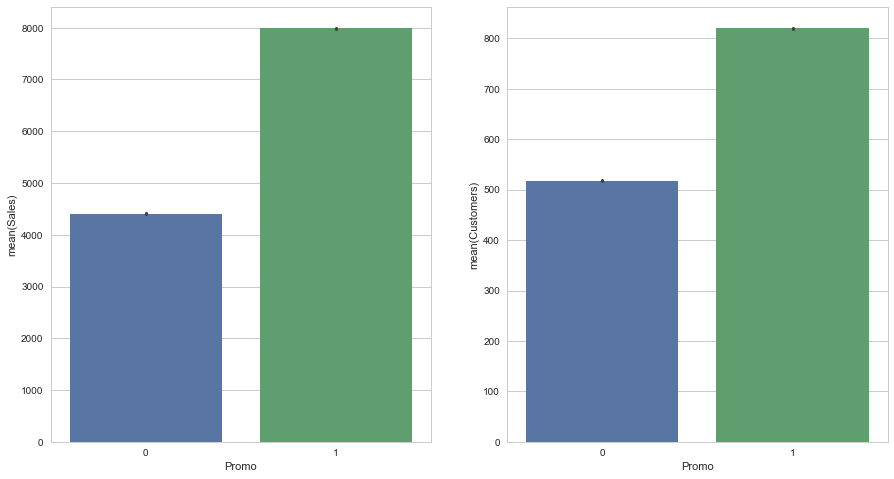

In [11]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,8))

seaborn.barplot(x='Promo', y='Sales', data=train2, ax=axis1)
seaborn.barplot(x='Promo', y='Customers', data=train2, ax=axis2)


Clearly when there's a promotion event going on there are more customers and more sales. Customers also buy more products when there's a promotion event.

We've explored the simple train set quite a bit, let's look briefly into the store data to see if we can find some relationship which would further help refine the least squares regression.

In [12]:
merged = pd.merge(train2, store, how='left', on='Store')

print('Information')
print(merged.info())
print('\n Sample')
merged.head(10)

Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
month_date                   1017209 non-null object
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek           

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month_date,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015-07,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,2015-07,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015-07,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015-07,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,2015-07,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,2015-07,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,2015-07,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,2015-07,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,2015-07,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,2015-07,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


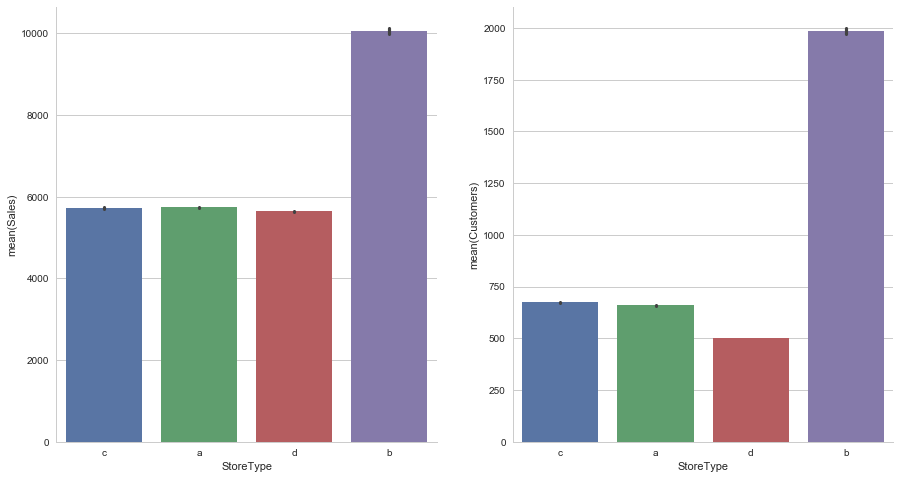

In [13]:
# StoreType

merged['StoreType'].unique()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
seaborn.despine()
seaborn.barplot(x='StoreType', y='Sales', data=merged, ax=ax1)
seaborn.barplot(x='StoreType', y='Customers', data=merged, ax=ax2)

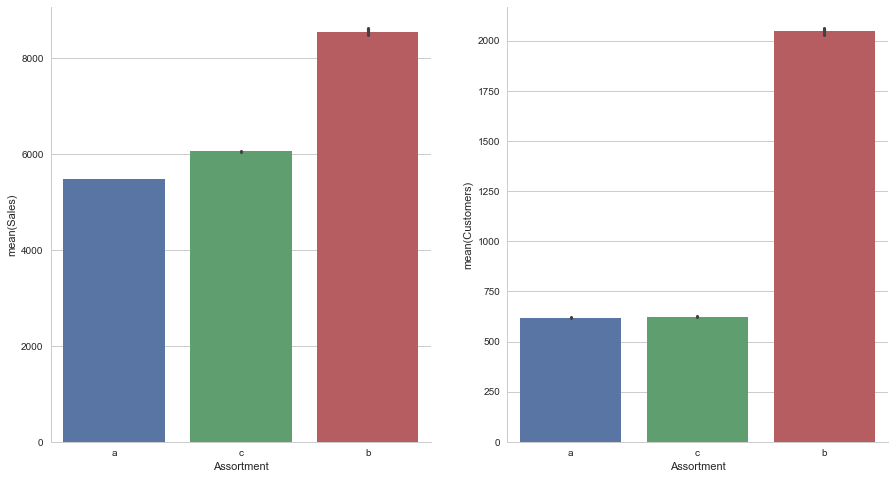

In [14]:
#Assortment

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
seaborn.despine()
seaborn.barplot(x='Assortment', y='Sales', data=merged, ax=ax1)
seaborn.barplot(x='Assortment', y='Customers', data=merged, ax=ax2)



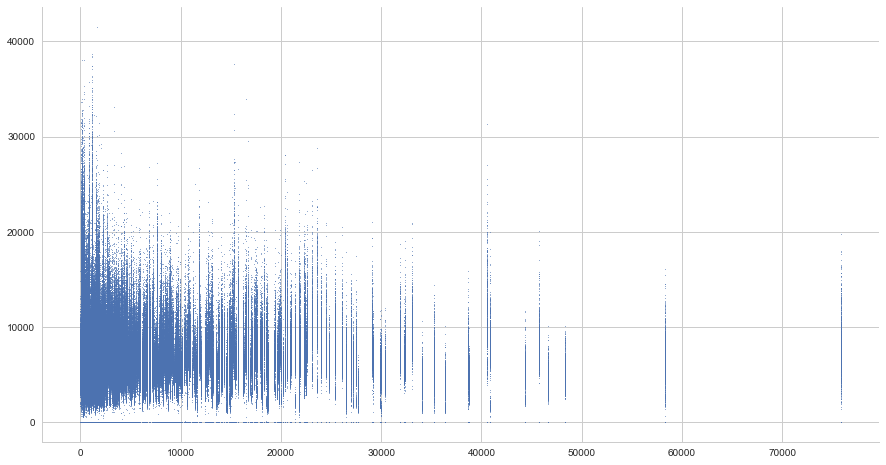

In [15]:
# CompetitionDistance

fig = plt.subplots(figsize=(15,8))
seaborn.despine()
plt.scatter(y=merged.Sales, x=merged.CompetitionDistance, s=0.2, marker='*')

Having explored most of the variables, we can now filter the dataset to get a model which will most accurately train our regression model.

In [16]:
merged.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month_date,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015-07,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,2015-07,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015-07,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015-07,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,2015-07,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,2015-07,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,2015-07,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,2015-07,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,2015-07,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,2015-07,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


# Feature selection

In [17]:
# Select the columns we will use as predictors in our model
train3 = merged[['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance']]

# Drop rows where the store is closed
train_final = train3[train3.Open==1]
train_final.drop(train_final[['Date', 'Open']], axis=1, inplace=True)

# As a second test I will limit the data set only within the relevant dates
train_final2 = train3[train3.Open==1]
date_mask = (train_final2.Date.apply(lambda x: str(x)[5:7]) == '08')|(train_final2.Date.apply(lambda x: str(x)[5:7]) == '09') 
train_final2 = train_final2[date_mask]

/Users/Max/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Polynomial fitting

/Users/Max/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: The fit may be poorly conditioned


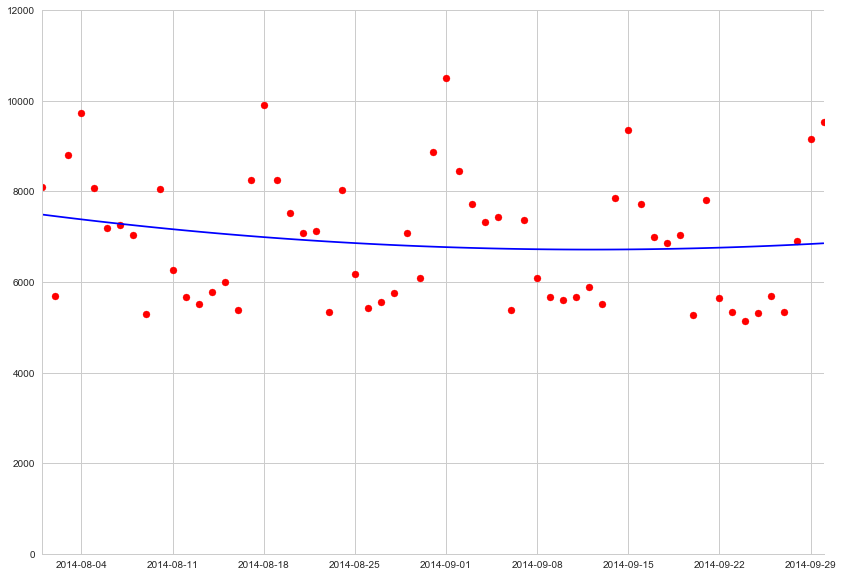

In [18]:
# test polynomial fit of average sales data in relevant datetime slice of dataset

import matplotlib.dates as mdates
from datetime import datetime
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

trend = train_final2[train_final2.Date.apply(lambda x: str(x)[:4]) == '2014'].copy()

trend.head()

trend.Date = pd.to_datetime(trend.Date)

# Calculate average sales per day
avg_sales = trend['Sales'].groupby(trend['Date']).mean()

# Calculate n-degree trendline

dates = avg_sales.index.tolist()
x = mdates.date2num(dates)
y = avg_sales
z = poly.polyfit(x, y, 3)
fx = poly.Polynomial(z)

# Plot
fig, ax = plt.subplots(figsize=(14,10))
plt.ylim(0, 12000) 
plt.xlim(x.min(), x.max())
seaborn.despine()

xx = np.linspace(x.min(), x.max(), 100)
dd = mdates.num2date(xx)

# Average sales
ax.scatter(avg_sales.index.tolist(), avg_sales, color='r')
ax.plot(dd, fx(xx), color='b')

plt.show()


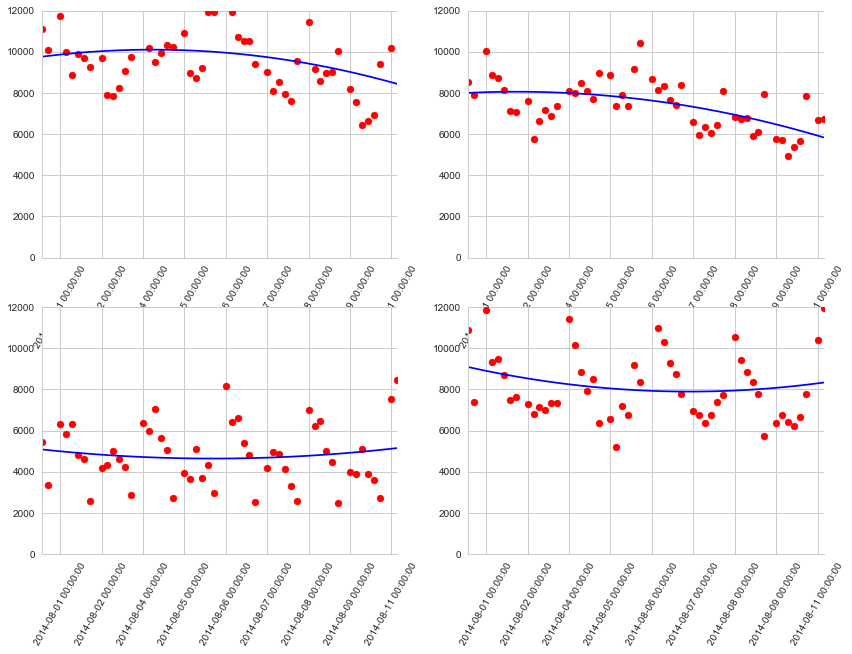

In [19]:
import matplotlib.dates as mdates
from datetime import datetime
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

trend2 = train_final2[train_final2.Date.apply(lambda x: str(x)[:4]) == '2014'].copy()

trend2.Date = pd.to_datetime(trend2.Date)

stores = [4, 68, 2, 90]

fig = plt.figure(figsize=(14,10))

# plot the trend for several individual stores
i = 1

for n in stores:
    trend2_store = trend2[trend2.Store==n] # random store

    # Calculate average sales per day
    avg_sales = trend2_store['Sales'].groupby(trend2_store['Date']).mean()

    dates = avg_sales.index.tolist()
    x = mdates.date2num(dates)
    y = avg_sales
    z = poly.polyfit(x, y, 2)
    fx = poly.Polynomial(z)

    # Plot Layout
    ax = fig.add_subplot(2,2,i)
    plt.ylim(0, 12000) 
    plt.xlim(x.min(), x.max())
    seaborn.despine()
    ax.set_xticklabels(avg_sales.index.tolist(), rotation=60)
    
    # Trendline
    xx = np.linspace(x.min(), x.max(), 61)
    dd = mdates.num2date(xx)

    # Plot
    ax.scatter(dates, y, color='r')
    ax.plot(dd, fx(xx), color='b')
    
    i = i + 1


plt.show()

In [20]:
 # Drop last unnecessary fields

train_final2.drop(train_final2[['Date', 'Open']], axis=1, inplace=True)

# Final data preparation

In [21]:
m = {
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4
}

avg_c_dist_train = train_final2['CompetitionDistance'].mean()

train_final2['StoreType'] = train_final2['StoreType'].map(m)
train_final2['Assortment'] = train_final2['Assortment'].map(m)
train_final2['CompetitionDistance'].fillna(avg_c_dist_train, inplace=True) # fill missing values with avg. distance

In [22]:
train_final.head(4)

,Store,DayOfWeek,Sales,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance
0,1,5,5263,1,1,c,a,1270.0
1,2,5,6064,1,1,a,a,570.0
2,3,5,8314,1,1,a,a,14130.0
3,4,5,13995,1,1,c,c,620.0


When fitting a polynomial function on the data within the relevant dates we see relatively good results, furthermore I think given the presence of long-term trends in time series, fitting a polynomial to the data and then running linear regression will give the best results.


In [23]:
# Merge and adapt the test dataframe

test_merge = pd.merge(test, store, how='left', on='Store')
# There's several NaN values for the Open column, let's map them to closed stores (Open = 0)

test_merge.Open = test_merge.Open.fillna(0)

test_final = test_merge[['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance']]

closed_store_ids = test_final['Id'][test_final['Open'] == 0].values
test_final = test_final[test_final.Open!=0]
test_final.drop(['Open', 'Date'], axis=1, inplace=True)

# map to float categories
test_final['StoreType'] = test_final['StoreType'].map(m)
test_final['Assortment'] = test_final['Assortment'].map(m)

# fill NaN's in test set
avg_c_dist_test = test_final['CompetitionDistance'].mean()
test_final['CompetitionDistance'].fillna(avg_c_dist_train, inplace=True)


In [24]:
print('Final Training Data Set')
print(train_final2.info())
print('\n Final Test Data Set')
print(test_final.info())

Final Training Data Set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 106743 entries, 322400 to 780829
Data columns (total 8 columns):
Store                  106743 non-null int64
DayOfWeek              106743 non-null int64
Sales                  106743 non-null int64
Promo                  106743 non-null int64
SchoolHoliday          106743 non-null int64
StoreType              106743 non-null int64
Assortment             106743 non-null int64
CompetitionDistance    106743 non-null float64
dtypes: float64(1), int64(7)
memory usage: 7.3 MB
None

 Final Test Data Set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 41087
Data columns (total 8 columns):
Id                     35093 non-null int64
Store                  35093 non-null int64
DayOfWeek              35093 non-null int64
Promo                  35093 non-null int64
SchoolHoliday          35093 non-null int64
StoreType              35093 non-null int64
Assortment             35093 non-null int64
Compet

# Training and prediction

A linear model after fitting the data to a 3rd-degree polynomial shows the best results. I did not check any polynomial of a higher-degree to prevent overfitting the data. If we want to make predictions for a different or longer period than specified in the test data set, the parameters should be removed from the training dataset.

In [26]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from pandas import Series

# We will train the model and predict values per store

train_dict = dict(list(train_final2.groupby('Store')))
test_dict = dict(list(test_final.groupby('Store')))
result = pd.Series()

for n in test_dict:
    
    store = train_dict[n]
    
    X = store.drop(['Sales', 'Store'], axis=1)
    y = store['Sales']  
    X_test = test_dict[n].copy()
    store_ids = X_test.Id
    X_test.drop(['Id', 'Store'], axis=1, inplace=True)
    
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())])
    #poly = PolynomialFeatures()
    #krr = KernelRidge()
    model.fit(X, y)
    z = model.predict(X_test)
    
    result = result.append(Series(z, index=store_ids))
    
result = result.append(Series(0, index=closed_store_ids))

submission = pd.DataFrame({'Id': result.index, 'Sales': result.values})
submission.to_csv('poly3.csv', index=False)

The resulting data has a mean-square error of __0.14938__ when submitted to Kaggle.